In [1]:
import geopandas as gpd
import pandas as pd
import os
from tqdm import tqdm
from shapely.geometry import Point,box
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def df_to_shapefile(df, output_path,lon='lon',lat='lat', epsg=4326, batch_size=10000):
    '''将 DataFrame 转换为 shapefile'''
    # 初始化一个空的 GeoDataFrame，并设置几何列
    combined_geo_df = gpd.GeoDataFrame(columns=df.columns.tolist() + ['geometry'])
    combined_geo_df.set_geometry('geometry', inplace=True)
    combined_geo_df.set_crs(epsg=epsg, inplace=True)

    total_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)
    df_iterator = (df.iloc[i:i + batch_size] for i in range(0, len(df), batch_size))
    
    for batch_df in tqdm(df_iterator, total=total_batches, desc="Processing batches"):
        geometry = [Point(xy) for xy in zip(batch_df[lon], batch_df[lat])]
        batch_geo_df = gpd.GeoDataFrame(batch_df, geometry=geometry)
        batch_geo_df.set_crs(epsg=epsg, inplace=True)
        combined_geo_df = pd.concat([combined_geo_df, batch_geo_df], ignore_index=True)
    
    combined_geo_df.to_file(output_path, driver='ESRI Shapefile')

In [2]:
os.chdir(r'G:\SETP_ICESat-2')
SETP_SHP = r"G:\SETP_Boundary.geojson"

ATL03_Water = pd.read_hdf("ATL_03_GlobalGeolocatedPhoton\ATL03_ALL\ATL03_Water.h5", key='df') # ATL03_ALL.h5
ATL03_ALL = pd.read_hdf("ATL_03_GlobalGeolocatedPhoton\ATL03_ALL\ATL03_ALL.h5", key='df') 
ATL06_ALL = pd.read_hdf("ATL_06_Landice\ATL06_ALL\ATL06_ALL.h5", key='df')
ATL08_ALL = pd.read_hdf("ATL_08_LandVegetation\ATL08_ALL\ATL08_ALL.h5", key='df')
ATL13_ALL = pd.read_hdf("ATL_13_InlandSurfaceWaterData\ATL13_ALL\ATL13_ALL.h5", key='df')

ATL03_Noise = pd.read_hdf(r"ATL_03_GlobalGeolocatedPhoton\ATL03_Noise\ATL03_Noise_ALL.h5", key='df')

print('ATL03冰湖数量{}'.format(len(ATL03_ALL['Sort'].unique())))
print('ATL03冰湖噪声数量{}'.format(len(ATL03_Noise['Sort'].unique())))
print('ATL06冰湖数量{}'.format(len(ATL06_ALL['Sort'].unique())))
print('ATL08冰湖数量{}'.format(len(ATL08_ALL['Sort'].unique())))
print('ATL13冰湖数量{}'.format(len(ATL13_ALL['Sort'].unique())))

print("噪声值存在水体信号>=3的冰湖数量{}".format(len(ATL03_ALL[ATL03_ALL['signal_conf_combined'].apply(lambda x: x[4] >=3)]['Sort'].unique())))
print("面积大于0.1的ATL03冰湖数量{}".format(len(ATL03_ALL[ATL03_ALL.Area_pre>0.1]['Sort'].unique())))

# # ATL03_ALL
# gdf = gpd.GeoDataFrame(ATL03_ALL,
#     geometry=[Point(xy) for xy in zip(ATL03_ALL['lon'], ATL03_ALL['lat'])],
#     crs="EPSG:4326"  # 设置坐标参考系为WGS 84
# )
# gdf.to_file('ATL03_ALL.shp', driver='ESRI Shapefile')


ATL03冰湖数量2143
ATL03冰湖噪声数量1170
ATL06冰湖数量1561
ATL08冰湖数量1298
ATL13冰湖数量48
噪声值存在水体信号>=3的冰湖数量1159
面积大于0.1的ATL03冰湖数量346


# 绘图，普通散点图

0.728904


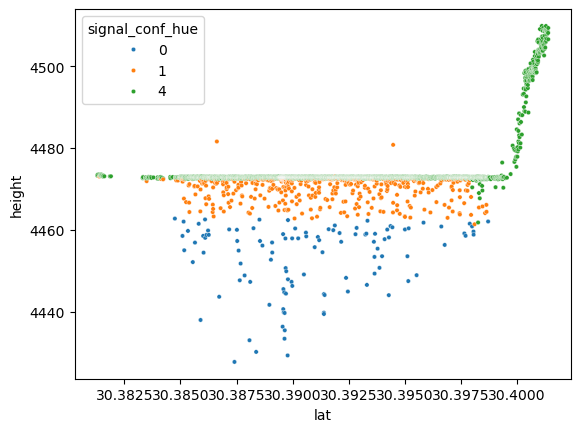

In [3]:
# 绘图，同时绘制ATL03、ATL06、ATL08、ATL13的散点图
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data
test = ATL03_ALL[(ATL03_ALL['Sort'] == 753) 
                 & (ATL03_ALL['date'] == '2023-11-24')
                 & (ATL03_ALL['subgroup'] == 'gt2r/')]
print(test['Area_pre'].mean())

# Extract the hue column from signal_conf_combined
test['signal_conf_hue'] = test['signal_conf_combined'].apply(lambda x: x[3] if isinstance(x, list) and len(x) > 3 else None)

# Use 'tab10' as the palette
sns.scatterplot(data=test, x='lat', y='height', hue='signal_conf_hue', palette='tab10', legend=True, s=10)

# Optionally set y-axis limits if needed
# plt.ylim(4240, 4260)
plt.show()

In [4]:
test

,time,date,lat,lon,height,dist_ph_along,quality_ph,signal_conf_combined,signal_conf_ph_Water,subgroup,Sort,Area_pre,signal_conf_hue
39818,1.860766e+08,2023-11-24,30.381293,95.888234,4473.295898,2.841787,0,"[4, -1, -1, 4, 4]",True,gt2r/,753.0,0.728904,4
39819,1.860766e+08,2023-11-24,30.381313,95.888232,4473.497070,4.975068,0,"[4, -1, -1, 4, 4]",True,gt2r/,753.0,0.728904,4
39820,1.860766e+08,2023-11-24,30.381370,95.888225,4473.542480,11.388924,0,"[4, -1, -1, 4, 4]",True,gt2r/,753.0,0.728904,4
39821,1.860766e+08,2023-11-24,30.381389,95.888222,4473.041992,13.525240,0,"[4, -1, -1, 1, 4]",True,gt2r/,753.0,0.728904,1
39822,1.860766e+08,2023-11-24,30.381396,95.888222,4473.371582,14.238887,0,"[4, -1, -1, 4, 4]",True,gt2r/,753.0,0.728904,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,1.860766e+08,2023-11-24,30.401364,95.885922,4508.052246,13.219754,0,"[4, -1, -1, 4, 4]",True,gt2r/,753.0,0.728904,4
47341,1.860766e+08,2023-11-24,30.401377,95.885920,4508.381836,14.634874,0,"[4, -1, -1, 4, 4]",True,gt2r/,753.0,0.728904,4
47342,1.860766e+08,2023-11-24,30.401383,95.885919,4508.138184,15.341185,0,"[4, -1, -1, 4, 4]",True,gt2r/,753.0,0.728904,4
47343,1.860766e+08,2023-11-24,30.401390,95.885919,4506.591309,16.043840,0,"[4, -1, -1, 4, 4]",True,gt2r/,753.0,0.728904,4


KeyboardInterrupt: 

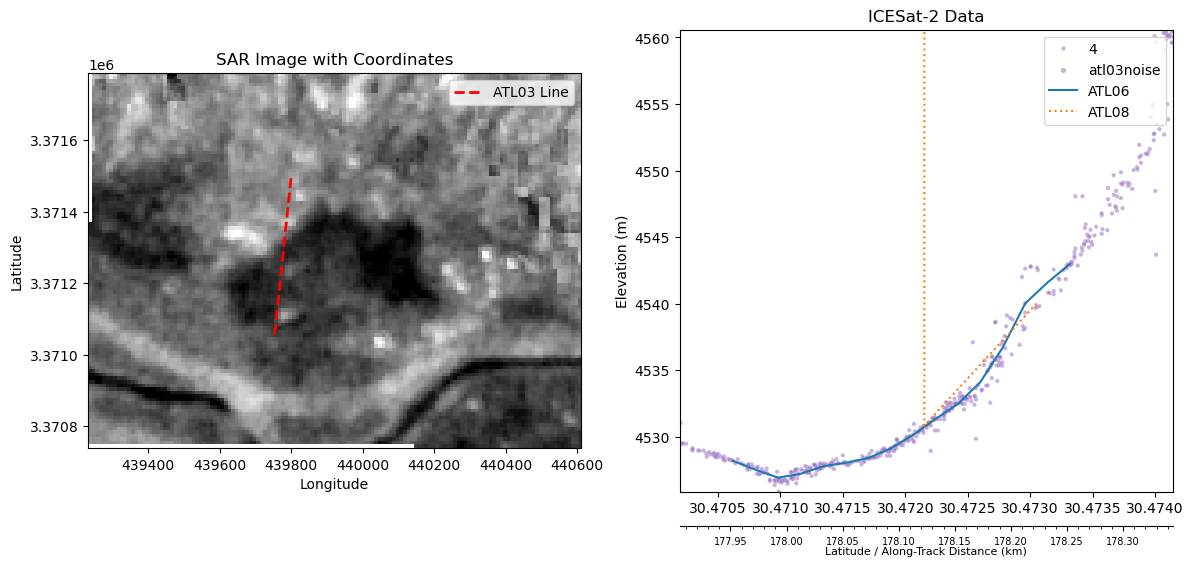

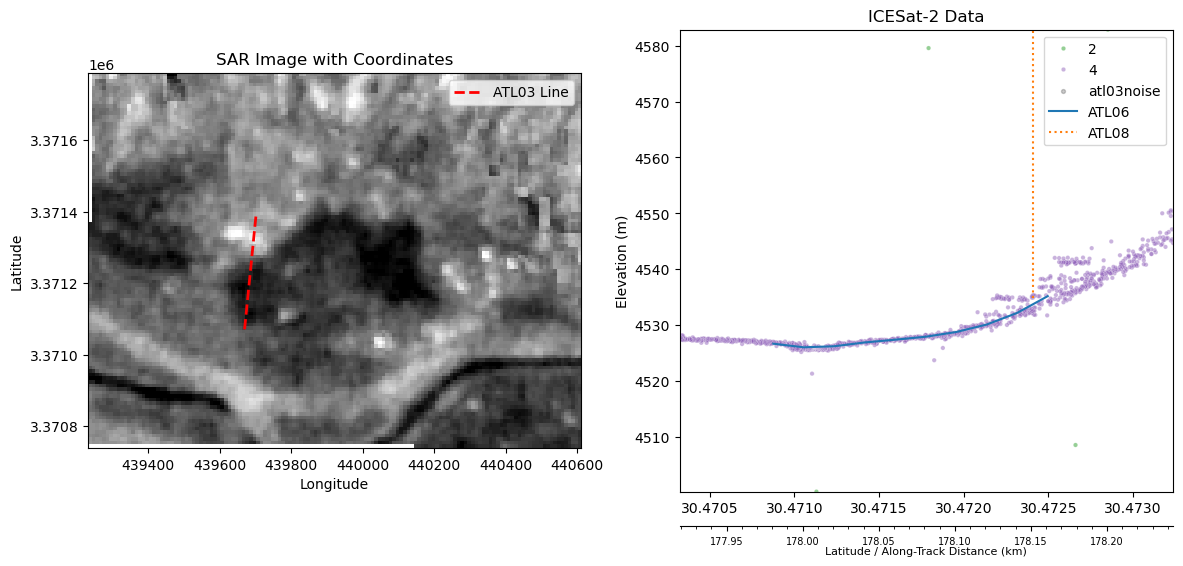

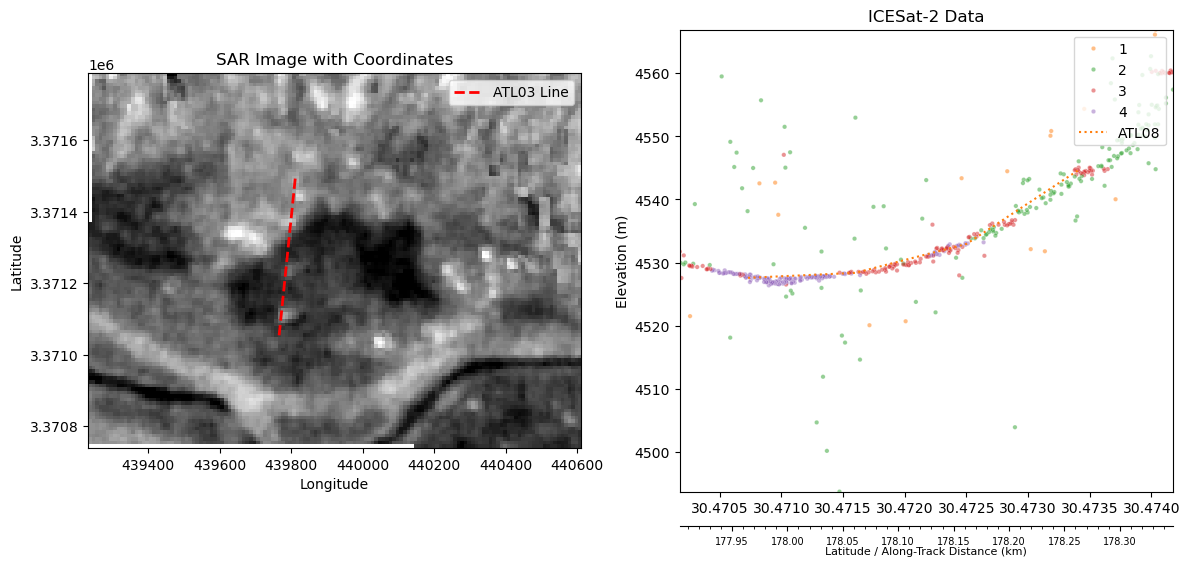

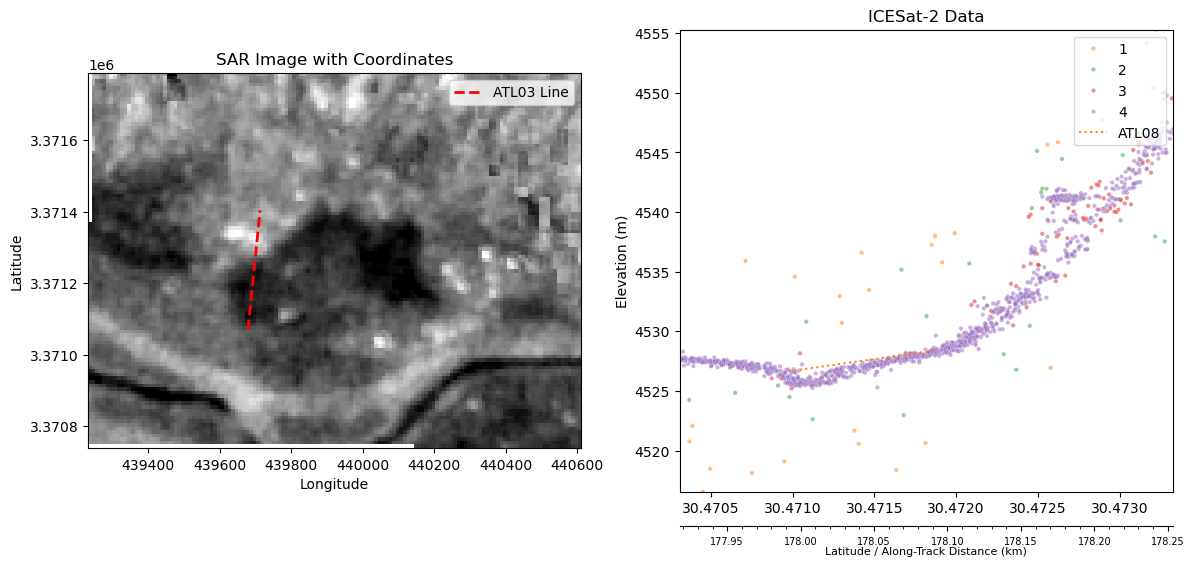

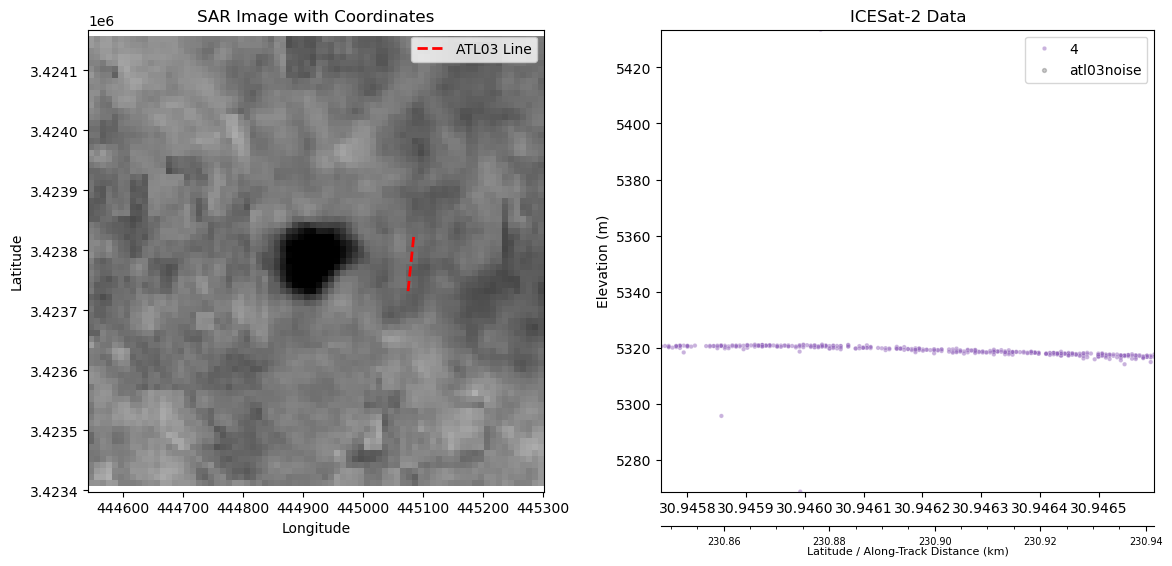

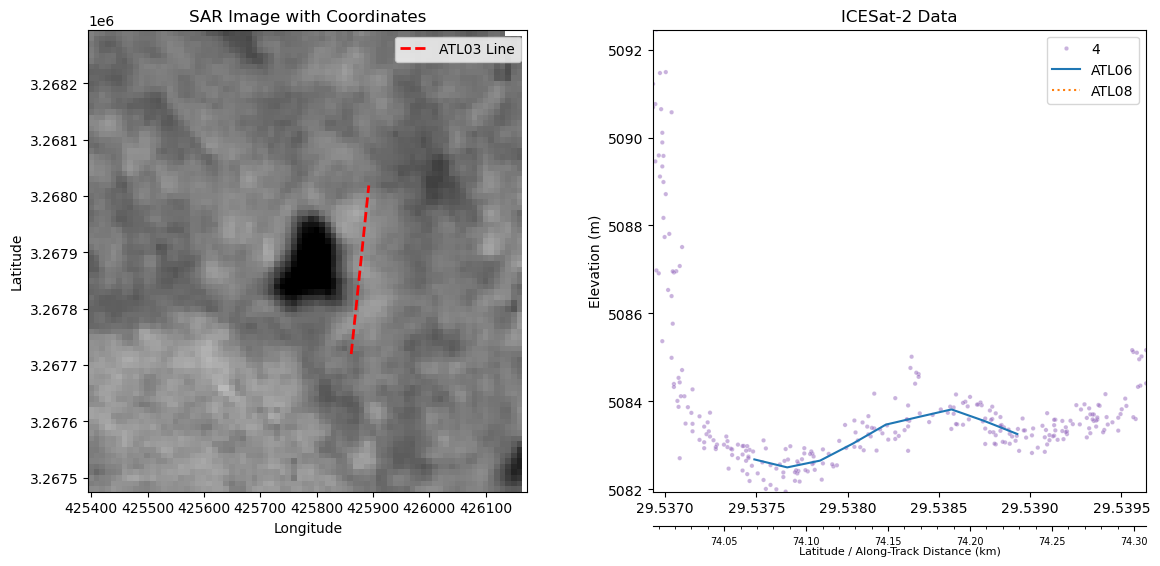

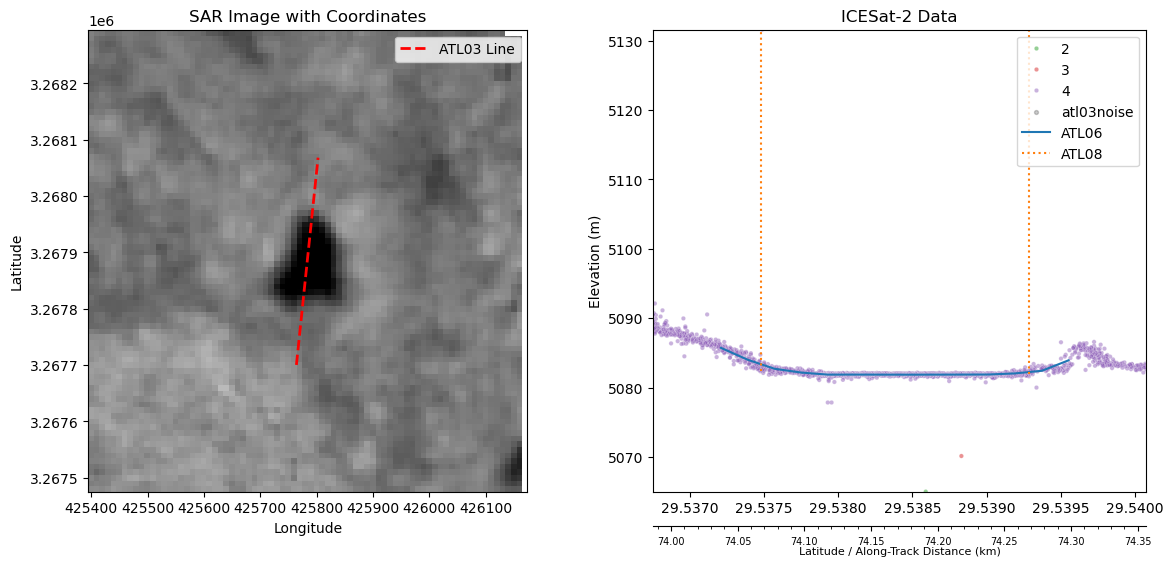

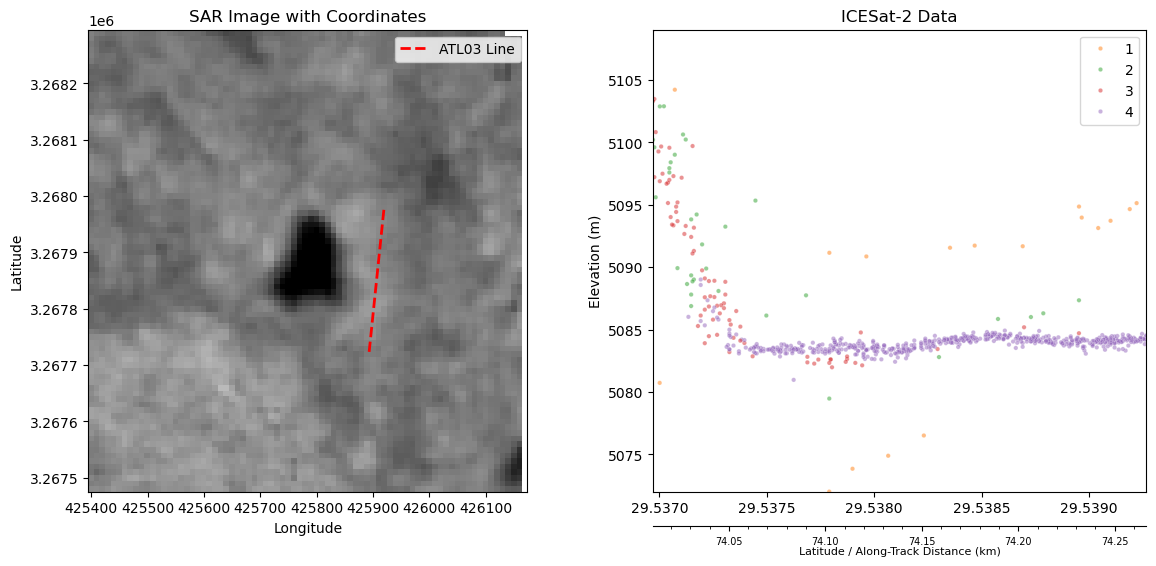

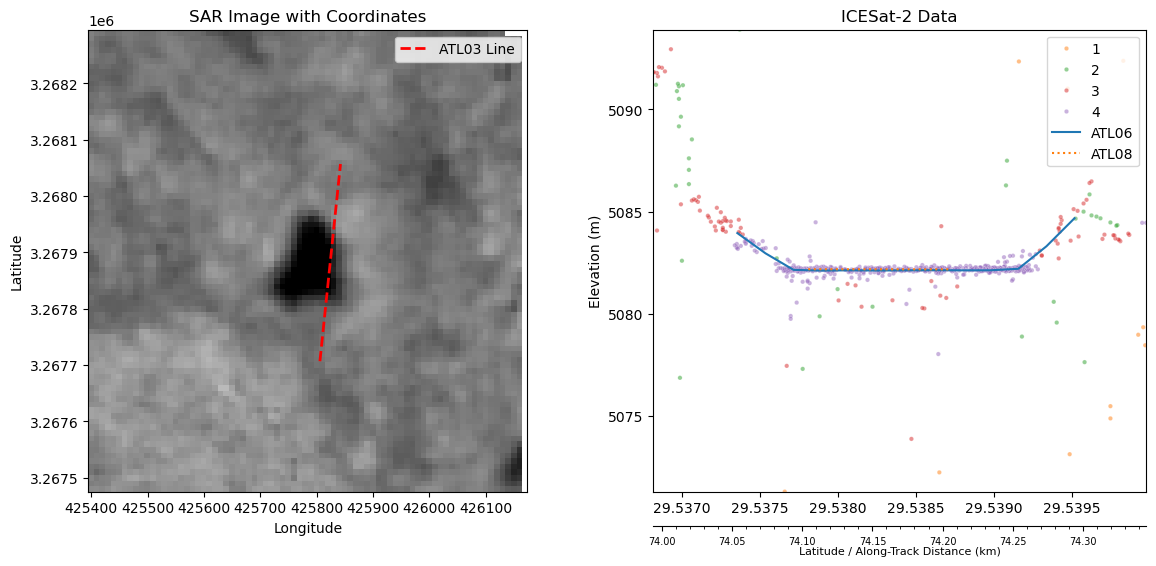

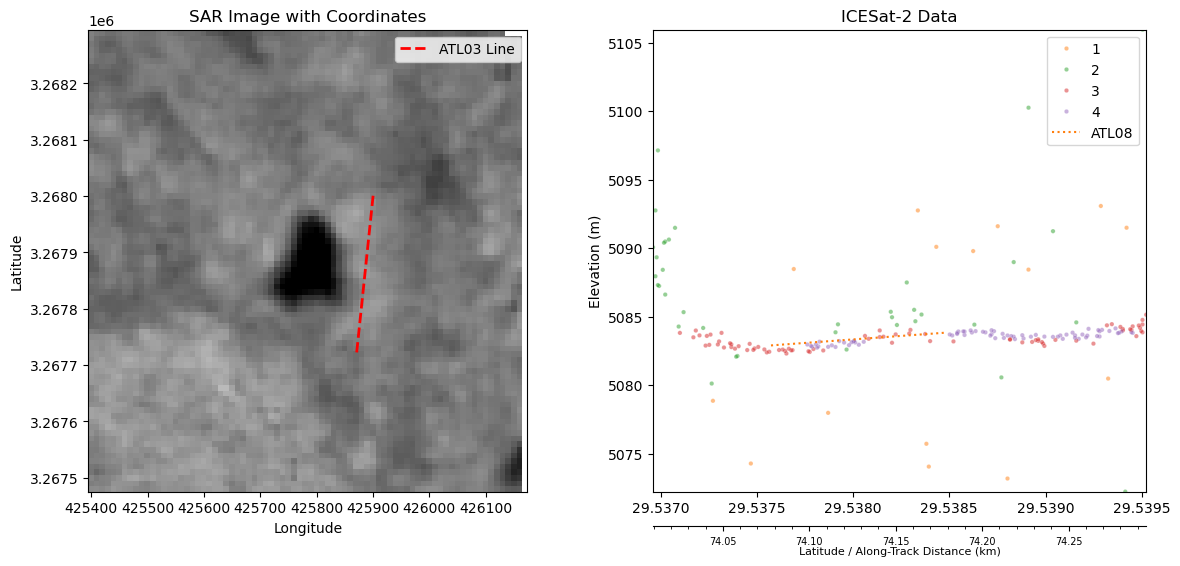

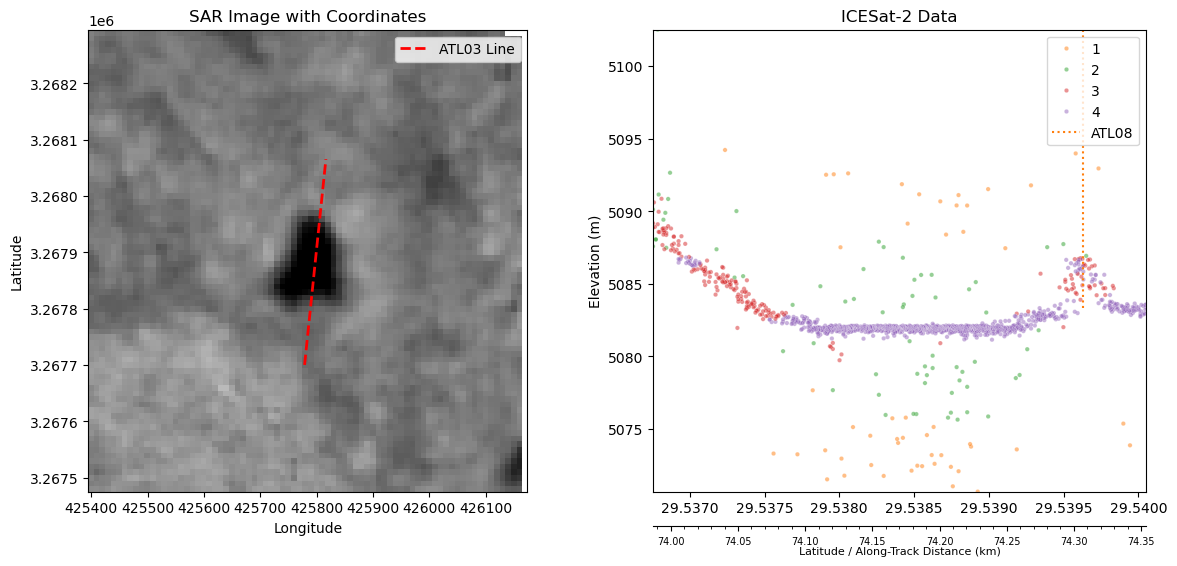

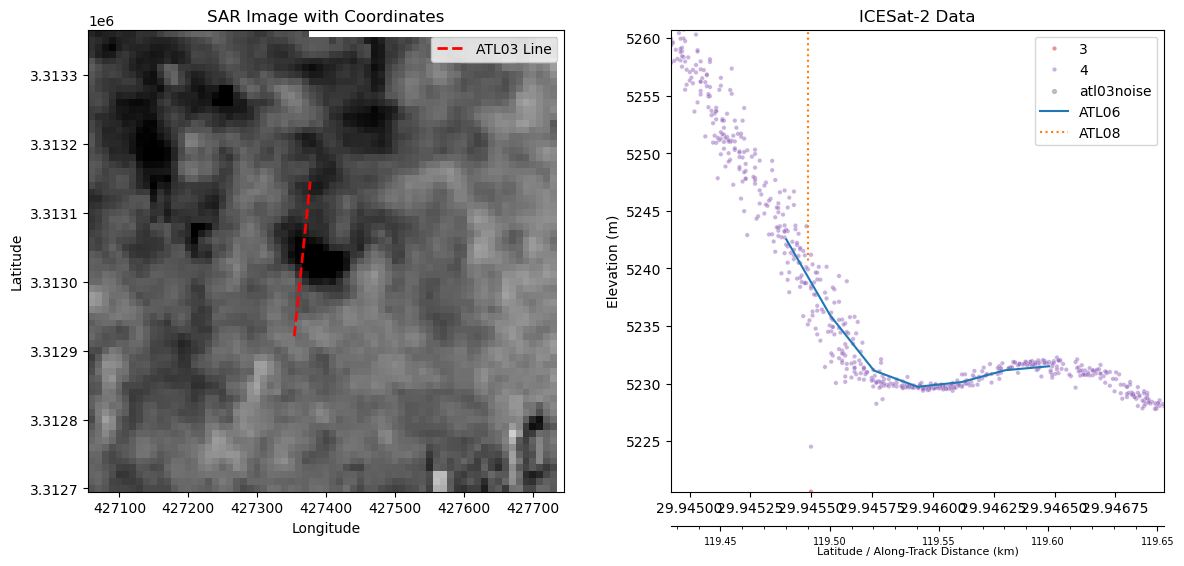

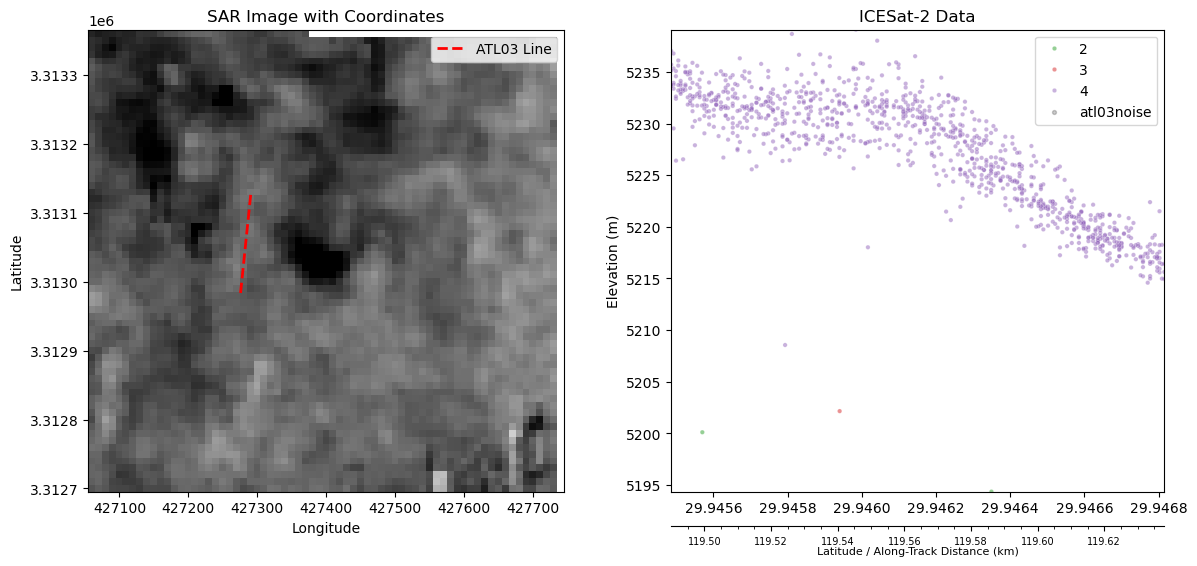

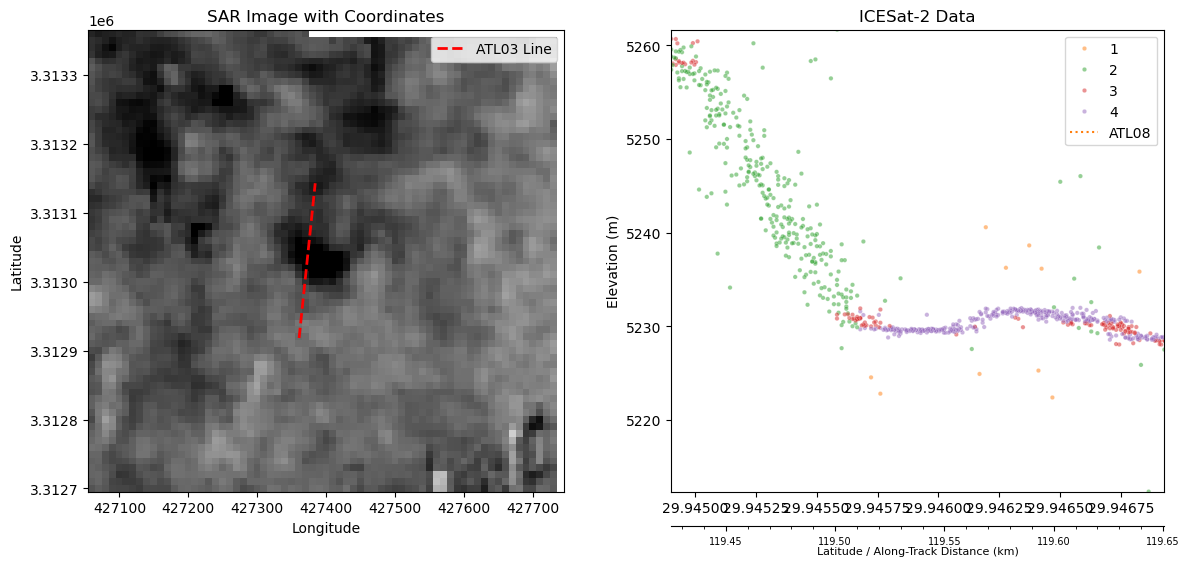

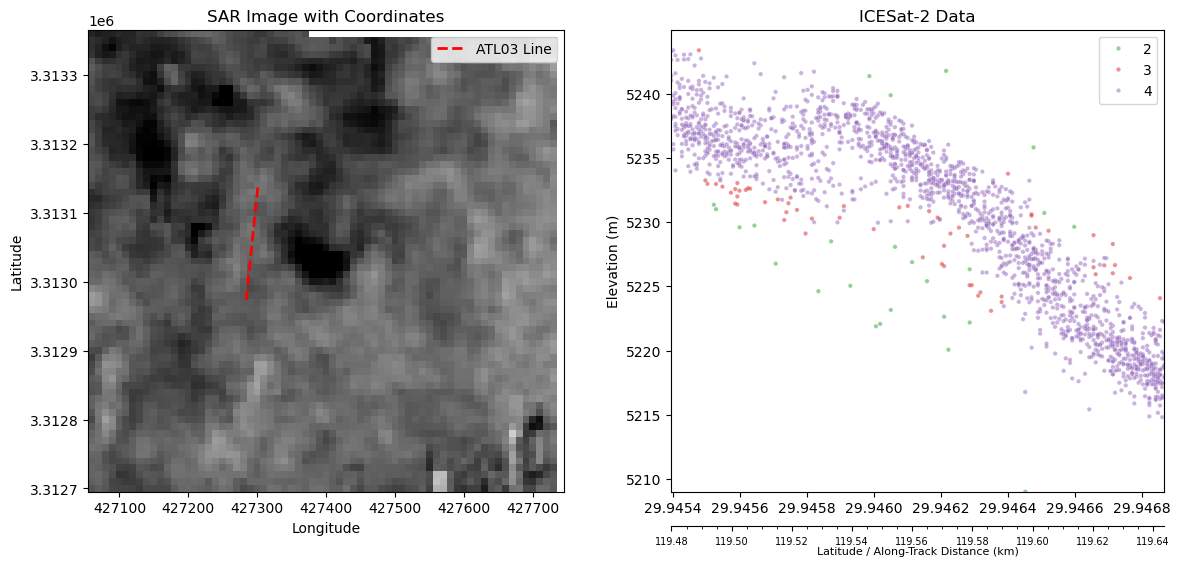

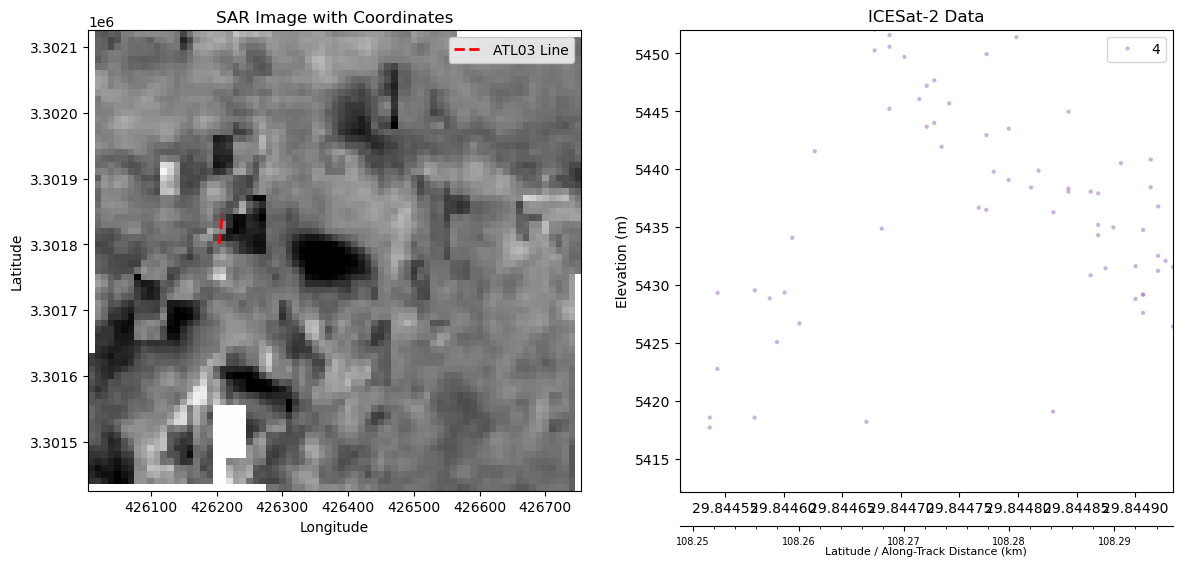

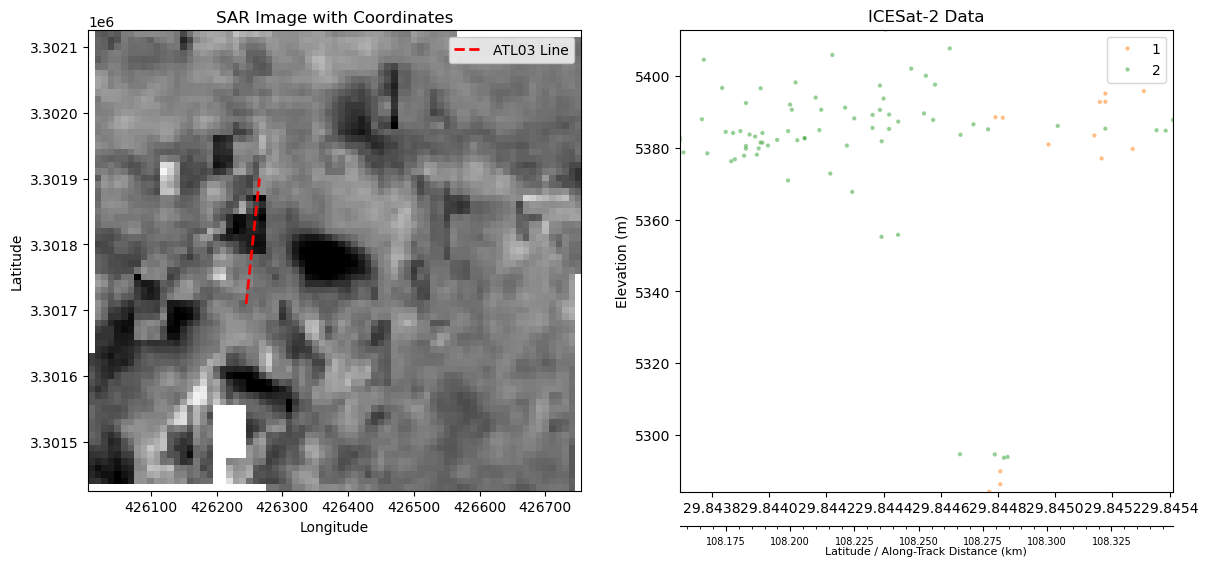

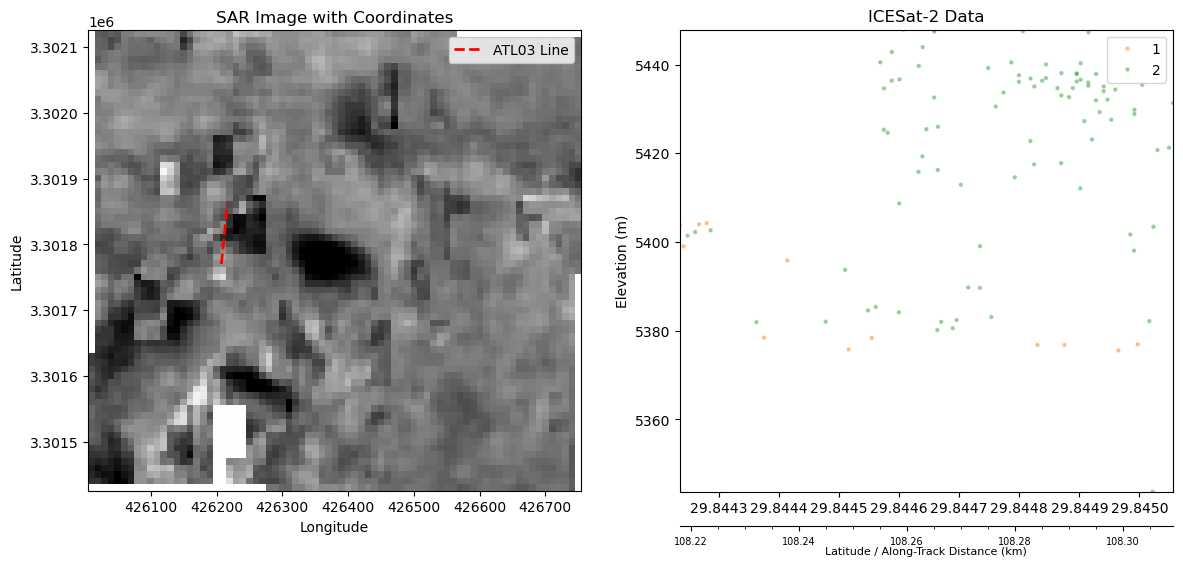

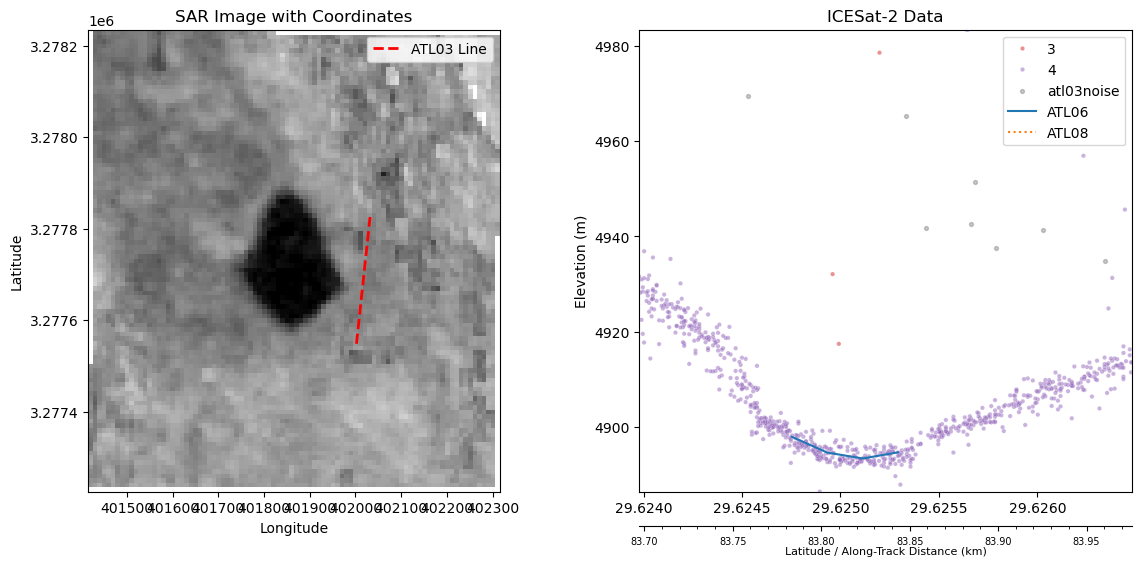

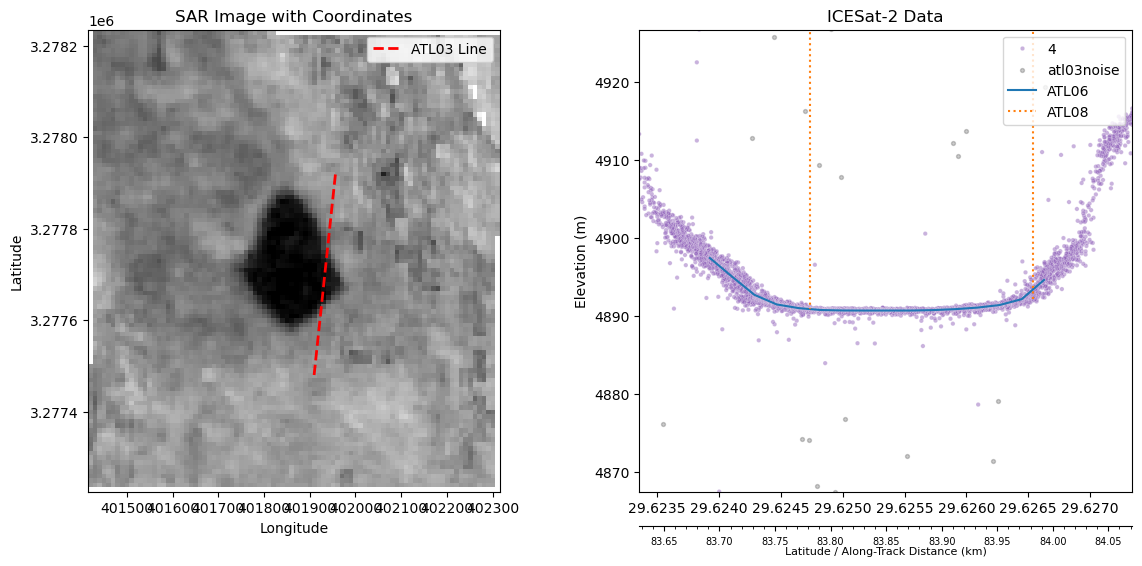

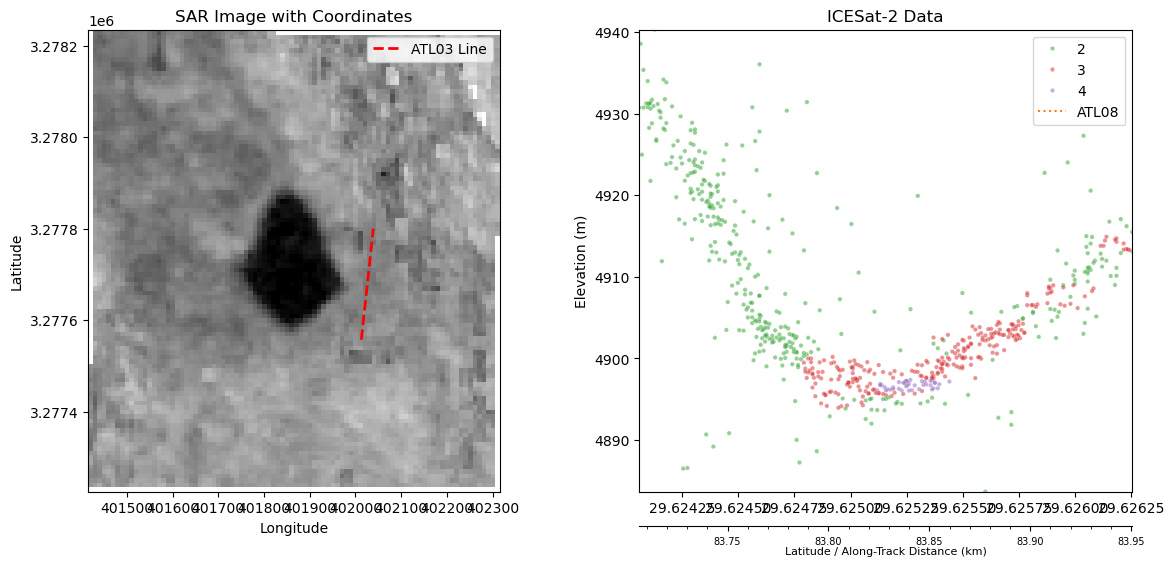

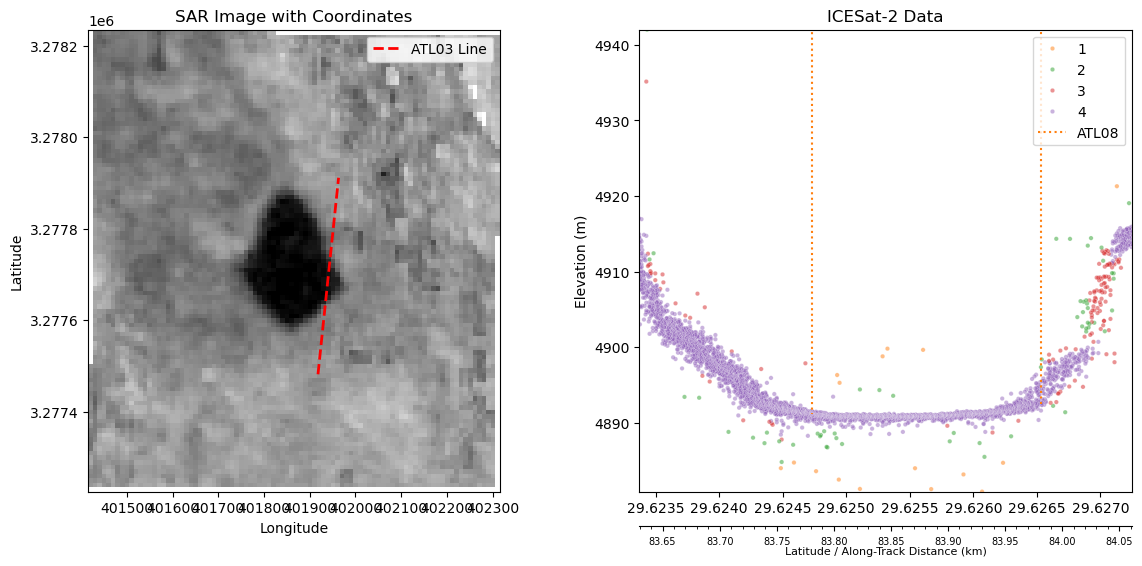

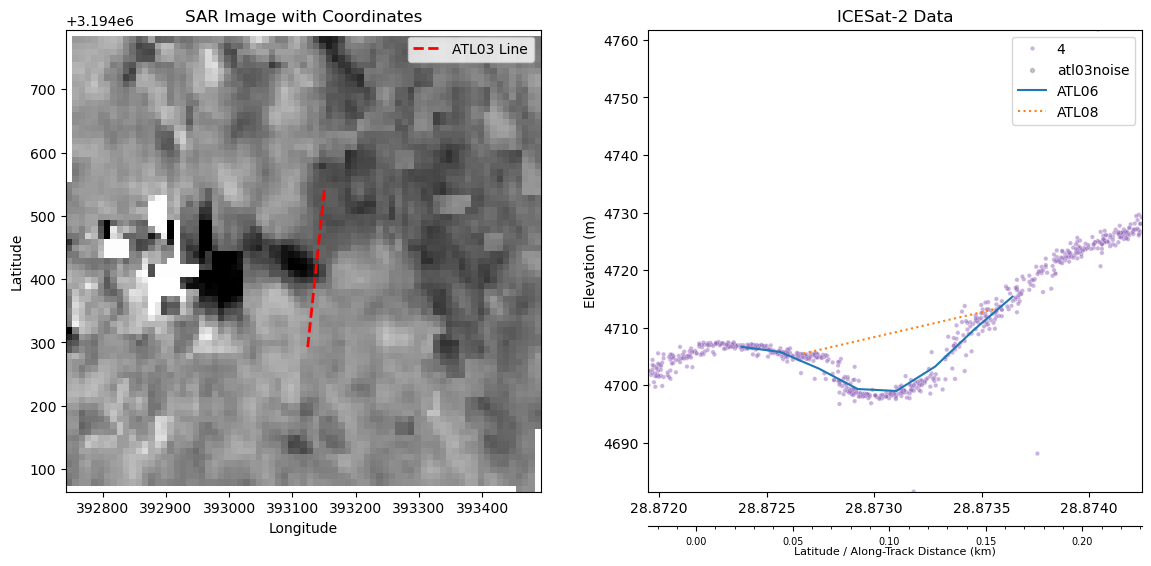

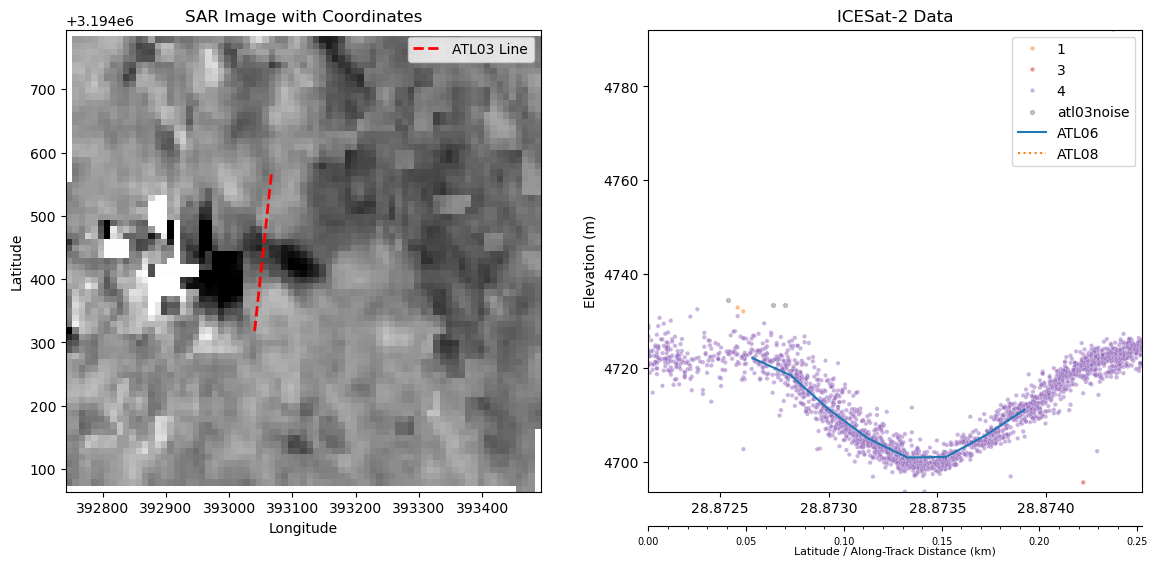

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show
from pyproj import Transformer
import os
import traceback
import pandas as pd

# Load the ID file and SAR image directory
Sorted_ID = gpd.read_file(r'D:\BaiduSyncdisk\02_论文相关\在写\SAM冰湖\数据\2023_05_31_to_2023_09_15_样本修正_SpatialJoin.shp')[['Sort','ID']]
SAR_imageDir = r'D:\Dataset_and_Demo\SETP_GL\2023-05-31_to_2023-09-15'
tab10_colors = sns.color_palette("tab10")
custom_palette = {0:tab10_colors[0],1:tab10_colors[1],2:tab10_colors[2],3:tab10_colors[3],4:tab10_colors[4],5:tab10_colors[5]}

for n,sort_value in enumerate(ATL03_ALL['Sort'].unique()):
    # if n < 219:
    #     print('{}exitst'.format(n))
    #     continue
    df_sort = ATL03_ALL[ATL03_ALL['Sort'] == sort_value]
    for date_value in df_sort['date'].unique():
        df_date = df_sort[df_sort['date'] == date_value]
        for subgroup_value in df_date['subgroup'].unique():
            df_group = df_date[df_date['subgroup'] == subgroup_value]
            
            
            Sort_num = sort_value
            date     = date_value
            subgroup = subgroup_value

            ID = int(Sorted_ID[Sorted_ID.Sort == Sort_num].ID)
            SAR_image_path = os.path.join(SAR_imageDir, f'{ID:05d}_Trans.tif')

            # Read the SAR image with rasterio to retain geospatial information
            with rasterio.open(SAR_image_path) as src:
                SAR_image = src.read(1)  
                SAR_bounds = src.bounds   
                SAR_transform = src.transform  
                SAR_crs = src.crs

            Selected_ATL03 = ATL03_ALL[(ATL03_ALL['Sort'] == Sort_num) & 
                                    (ATL03_ALL['date'] == date) &
                                    (ATL03_ALL['subgroup'] == subgroup)].copy()
            Selected_ATL03.rename(columns={'height': 'h'}, inplace=True)
            
            Selected_ATL03_Noise = ATL03_Noise[(ATL03_Noise['Sort'] == Sort_num) &
                                    (ATL03_Noise['date'] == date) &
                                    (ATL03_Noise['subgroup'] == subgroup)].copy() 
            Selected_ATL03_Noise.rename(columns={'height': 'h'}, inplace=True)

            Selected_ATL06 = ATL06_ALL[(ATL06_ALL['Sort'] == Sort_num) & 
                                    (ATL06_ALL['date'] == date) &
                                    (ATL06_ALL['subgroup'] == subgroup)].copy()
            Selected_ATL06.rename(columns={'height': 'h'}, inplace=True)

            Selected_ATL08 = ATL08_ALL[(ATL08_ALL['Sort'] == Sort_num) & 
                                    (ATL08_ALL['date'] == date) &
                                    (ATL08_ALL['subgroup'] == subgroup)].copy()
            Selected_ATL08.rename(columns={'height_centroid': 'h'}, inplace=True)

            Selected_ATL13 = ATL13_ALL[(ATL13_ALL['Sort'] == Sort_num) & 
                                    (ATL13_ALL['date'] == date) &
                                    (ATL13_ALL['subgroup'] == subgroup)].copy()
            Selected_ATL13.rename(columns={'height_surface': 'h'}, inplace=True)
            
            if len(Selected_ATL03) <5 :
                print('{}_{}_{}_{}ALT03数据点数量不足'.format(Sort_num, date, subgroup[0:4],n))
                continue

            # Data collection class
            class dataCollector:
                def __init__(self, dataDF_list=[], datatype=[]):
                    try:
                        if 'ATL_03' in datatype:
                            self.atl03 = dataDF_list[datatype.index('ATL_03')]
                        if 'ATL_03Noise' in datatype:
                            self.atl03noise = dataDF_list[datatype.index('ATL_03Noise')]
                        if 'ATL_06' in datatype:
                            self.atl06 = dataDF_list[datatype.index('ATL_06')]
                        if 'ATL_08' in datatype:
                            self.atl08 = dataDF_list[datatype.index('ATL_08')]
                        if 'ATL_13' in datatype:
                            self.atl13 = dataDF_list[datatype.index('ATL_13')]
                    except IndexError as e:
                        print("Error initializing dataCollector:", e)

                def plotData(self, ax=None, title='ICESat-2 Data'):
                    try:
                        # Check if ATL03 data is available
                        if not hasattr(self, 'atl03') or self.atl03 is None:
                            print("ATL03 data is missing.")
                            return

                        # Create or use the provided ax
                        if ax is None:
                            fig, ax = plt.subplots()

                        # Plot ATL03 data
                        if hasattr(self, 'atl03') and not self.atl03.empty:
                            # self.atl03['signal_conf_hue'] = self.atl03['signal_conf_combined'].apply(lambda x: x[3] if isinstance(x, list) and len(x) > 3 else None)
                            self.atl03['signal_conf_hue'] = self.atl03['signal_conf_combined'].apply(lambda x: max(x) if isinstance(x, list) else None)
                            # ax.scatter(self.atl03.lat, self.atl03.h, s=2, color='black', alpha=0.2, label='ATL03')

                            sns.scatterplot(data=self.atl03, x='lat', y='h', hue='signal_conf_hue', palette=custom_palette,alpha=0.5, legend=True, s=10)
                        if hasattr(self, 'atl03noise') and not self.atl03noise.empty:
                            ax.scatter(self.atl03noise.lat, self.atl03noise.h, s=8, color='black', alpha=0.2, label='atl03noise')
                            
                        # Plot other ATL datasets
                        for attr, color, style, label in [
                            ('atl06', 'C0', '-', 'ATL06'),
                            ('atl08', 'C1', ':', 'ATL08'),
                            ('atl13', 'C5', ':', 'ATL13')
                        ]:
                            if hasattr(self, attr) and not getattr(self, attr).empty:
                                ax.plot(getattr(self, attr).lat, getattr(self, attr).h, c=color, linestyle=style, label=label)

                        # Set x and y axis limits based on the data range
                        ax.set_xlim(self.atl03.lat.min(), self.atl03.lat.max())
                        ax.set_ylim(self.atl03.h.min(), self.atl03.h.max())
                        ax.ticklabel_format(useOffset=False, style='plain')
                        # ax.set_ylim(self.atl03[self.atl03.signal_conf_ph_Water].h.min()-30, self.atl03[self.atl03.signal_conf_ph_Water].h.max()+30)
                        # Labels and legend
                        ax.set_title(title)
                        ax.set_xlabel('')
                        ax.set_ylabel('Elevation (m)')
                        ax.legend(loc='upper right')

                        return ax

                    except Exception as e:
                        print("Plotting ICESat-2 data was unsuccessful.")
                        traceback.print_exc()

            # Create dataCollector object and plot
            dataDF_list = [Selected_ATL03,Selected_ATL03_Noise, Selected_ATL06, Selected_ATL08, Selected_ATL13]
            datatype = ['ATL_03','ATL_03Noise', 'ATL_06', 'ATL_08', 'ATL_13']
            s = dataCollector(dataDF_list=dataDF_list, datatype=datatype)

            # Create subplot with SAR image on the left and ICESat-2 data on the right
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

            # Display SAR image with rasterio bounds
            if SAR_image is not None:
                show(SAR_image, ax=ax1, transform=SAR_transform, cmap='gray')
                ax1.set_title('SAR Image with Coordinates')
                ax1.set_xlabel('Longitude')
                ax1.set_ylabel('Latitude')

            try:
                # Get the min and max latitude of ATL03 data
                min_lat = Selected_ATL03['lat'].min()
                max_lat = Selected_ATL03['lat'].max()

                # Find corresponding longitudes for these latitudes
                min_lon = Selected_ATL03.loc[Selected_ATL03['lat'].idxmin(), 'lon']
                max_lon = Selected_ATL03.loc[Selected_ATL03['lat'].idxmax(), 'lon']

                # Convert geographic coordinates to EPSG:32646
                transformer = Transformer.from_crs("EPSG:4326", SAR_crs, always_xy=True)
                x_min, y_min = transformer.transform(min_lon, min_lat)
                x_max, y_max = transformer.transform(max_lon, max_lat)

                # Plot the line segment from min_lat to max_lat
                ax1.plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=2, label='ATL03 Line')
                ax1.legend(loc='upper right')

            except Exception as e:
                print("Error in projecting and plotting ATL03 boundary.")
                traceback.print_exc()



            lat = [min_lat, max_lat]
            xatc = [0, np.sqrt((y_max - y_min)**2 + (x_max - x_min)**2) / 1000]  # distance in km

            def lat2xatc(l):
                return xatc[0] + (l - lat[0]) * (xatc[1] - xatc[0]) / (lat[1] - lat[0])

            def xatc2lat(x):
                return lat[0] + (x - xatc[0]) * (lat[1] - lat[0]) / (xatc[1] - xatc[0])

            # Display ICESat-2 data and add the secondary x-axis
            s.plotData(ax=ax2, title='ICESat-2 Data')

            # Add the secondary x-axis for along-track distance
            secax = ax2.secondary_xaxis(-0.075, functions=(lat2xatc, xatc2lat))
            secax.xaxis.set_minor_locator(mticker.AutoMinorLocator())
            secax.set_xlabel('Latitude / Along-Track Distance (km)', fontsize=8, labelpad=0)
            secax.tick_params(axis='both', which='major', labelsize=7)
            secax.ticklabel_format(useOffset=False, style='plain')  # show actual latitude values without scientific notation

            plt.savefig('Plot_for_Recon_withNoise/{}_{}_{}_{}.jpg'.format(Sort_num, date, subgroup[0:4],n))